In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
! pip install pandasql

  Running setup.py bdist_wheel for pandasql ... done
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
https://www.kaggle.com/ealaxi/paysim1

In [ ]:
Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. 
Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. 
Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. 
PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour 
to later evaluate the performance of fraud detection methods.

Content
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. 
The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. 
          In this specific dataset the fraudulent behavior of the agents aims to profit by taking control 
            or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
                 An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Past Research
There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932).

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. 
Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. 
The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

Acknowledgements
This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded
by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

In [3]:
# labrary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# deactivate scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# useful functions

def describe(df, stats):
    """using the pandas describe method and adding more information to it
       
       INPUT: df = dataframe in question
              stats = extra stats needed
              
       OUTPUT: dataframe with stats for the numric columns of the dataset"""
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

In [5]:
# read data
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,0.000
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,0.000
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,0.000
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,0.000
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,0.000


## Exploratory Analysis

# 1)describe data
# 2)drop missing values/rows
# 3)check the target flags per type
# 4)check validity of 'newbalanceOrig' field
# 5)check if isFraud is correclty as per the definition
# 6)create C/M flags for Org-Dest entities                         - EXPLORE
# 7)collect all orig/den that are involed in a fraud (isFraud = 1) - THINK WHAT TO DO WITH THAt
# 8)create direction of transactions overall for each custom within the dataset

### 1)describe data

In [6]:

print("data shape : {}\n".format(data.shape))
display(data.info())

display(describe(data, ['skew', 'mad', 'kurt', 'sum']))


data shape : (4693572, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4693572 entries, 0 to 4693571
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           float64
isFlaggedFraud    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 393.9+ MB


None

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,4693572.000,4693572.000,4693572.000,4693572.000,4693571.000,4693571.000,4693571.000,4693571.000
mean,181.574,180175.021,840375.260,862111.769,1053693.336,1184523.670,0.001,0.000
std,99.363,652119.942,2913602.980,2950268.710,2996798.067,3371071.491,0.028,0.001
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,132.000,13097.843,0.000,0.000,0.000,0.000,0.000,0.000
50%,189.000,75691.155,14057.000,0.000,136790.200,220114.430,0.000,0.000
75%,259.000,209478.315,107915.000,146472.955,944709.845,1118495.210,0.000,0.000
max,331.000,92445516.640,43818855.300,43686616.330,355553416.300,355553416.300,1.000,1.000
skew,-0.386,32.203,5.216,5.147,18.535,19.104,35.454,1250.808
mad,82.473,181930.825,1377251.685,1408640.286,1344363.094,1463311.662,0.002,0.000


### 2)drop missing values/rows

In [7]:
# drop the following row:
display(data.loc[(data['isFlaggedFraud'].isnull())|(data['isFraud'].isnull())])

# 1 record does not have target variable available. Drop this record as it adds up to nothing
data = data.loc[(data['isFlaggedFraud'].notna())|(data['isFraud'].notna())]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4693571,331,CASH_IN,4683.280,C212390777,21788.000,26471.280,C154711,nan,nan,nan,nan


### 3)check the target flags per type

In [8]:
print("count of records per transaction type")
display(data[['type','isFlaggedFraud','isFraud']].groupby(['type']).agg({'isFlaggedFraud':['count','sum'],'isFraud':['count','sum']}))



count of records per transaction type


isFlaggedFraud        isFraud         
                  count   sum    count      sum
type                                           
CASH_IN         1028902 0.000  1028902    0.000
CASH_OUT        1667601 0.000  1667601 1872.000
DEBIT             29203 0.000    29203    0.000
PAYMENT         1578507 0.000  1578507    0.000
TRANSFER         389358 3.000   389358 1853.000

### 4)check validity of 'newbalanceOrig' field

In [9]:
print("check how many records have amount > tha oldbalanceOrg")
# in cash in we add up the amount + the original balance, as it is earnings
# rest are expenses for the originator
data['recalc_newbalance_org'] = np.where(data['type']=='CASH_IN', np.ceil(data['oldbalanceOrg'] + data['amount'])
                                                                , np.where(np.ceil(data['oldbalanceOrg'] - data['amount'])<0,0,np.ceil(data['oldbalanceOrg'] - data['amount'])))


conditions = [ # are equal or recalc_newbalance_org-1<=newbalanceOrig<=recalc_newbalance_org+1 - weird roundings
    ((data['recalc_newbalance_org'] == np.ceil(data['newbalanceOrig']))|((data['newbalanceOrig'] <= np.ceil(data['recalc_newbalance_org'])+1)&(data['newbalanceOrig'] >= np.ceil(data['recalc_newbalance_org'])-1))),
    (data['recalc_newbalance_org'] > np.ceil(data['newbalanceOrig'])),
    (data['recalc_newbalance_org'] < np.ceil(data['newbalanceOrig']))
             ]
choices = ['equals', 'error: recalc > df - org sent more than having', 'error: recalc < df: was left with more than expecting']
data['recalc_vs_df_newbalance_org'] = np.select(conditions, choices, default='missing')
data[['recalc_vs_df_newbalance_org','isFlaggedFraud']].groupby(['recalc_vs_df_newbalance_org']).count()

check how many records have amount > tha oldbalanceOrg


,isFlaggedFraud
recalc_vs_df_newbalance_org,
equals,4693506
error: recalc < df: was left with more than expecting,8
error: recalc > df - org sent more than having,57


In [10]:
data.loc[(data['recalc_vs_df_newbalance_org']!='equals')].head()

# newbalanceOrig is acting weird

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org
456,1,CASH_IN,110226.340,C1475192960,1601450.630,1601450.630,C1816757085,1601450.630,10681238.790,0.000,0.000,1711677.000,error: recalc > df - org sent more than having
656,1,CASH_IN,770537.370,C2015999862,8499043.130,8499043.130,C1883840933,8499043.130,16874643.090,0.000,0.000,9269581.000,error: recalc > df - org sent more than having
1292,1,CASH_IN,61505.910,C1790387225,4910403.440,4910403.440,C11003494,4910403.440,10588885.270,0.000,0.000,4971910.000,error: recalc > df - org sent more than having
1293,1,CASH_IN,404167.600,C984412970,4910403.440,4910403.440,C11003494,4910403.440,10588885.270,0.000,0.000,5314572.000,error: recalc > df - org sent more than having
1591,1,CASH_OUT,30308.450,C1949126165,88926.200,88926.200,C1568059495,88926.200,122750.490,0.000,0.000,58618.000,error: recalc < df: was left with more than ex...


In [18]:
# create flag to show when amount ns > than initial balance
# if type = Cash_id it doesnt matter
# for anything else it does. it has to be -1 does to weird randoung of the values that exist in the data
# 0 = amount is not great than initial balance or it doesnt matter
# 1 means ammount is mrea than initial balance for transfers/payments/cash_outs so where did they get the money if it wasnt there!

data['amt_gt_initBalance'] = np.where(data['type']=='CASH_IN', 0
                                      , np.where(np.ceil(data['oldbalanceOrg'] - data['amount'])<-1,1,0))

display(data[['amt_gt_initBalance', 'isFraud','isFlaggedFraud','nameOrig']].groupby(['amt_gt_initBalance', 'isFraud','isFlaggedFraud']).count())

# most frauds happen when there is enough money in the balance to pull

display(data[['type','amt_gt_initBalance', 'isFraud','nameOrig']].groupby(['type','amt_gt_initBalance', 'isFraud']).count())

# cash out and transfers seem to have more fraududent trans when the amount is within the balance

nameOrig
amt_gt_initBalance isFraud isFlaggedFraud          
0                  0.000   0.000            2031597
                   1.000   0.000               3693
                           1.000                  3
1                  0.000   0.000            2658249
                   1.000   0.000                 29

nameOrig
type     amt_gt_initBalance isFraud          
CASH_IN  0                  0.000     1028902
CASH_OUT 0                  0.000      187312
                            1.000        1848
         1                  0.000     1478417
                            1.000          24
DEBIT    0                  0.000       20579
         1                  0.000        8624
PAYMENT  0                  0.000      778753
         1                  0.000      799754
TRANSFER 0                  0.000       16051
                            1.000        1848
         1                  0.000      371454
                            1.000           5

In [12]:
data['recalc_newbalance_org'] = np.where(data['type']=='CASH_IN', np.ceil(data['oldbalanceOrg'] + data['amount']),np.ceil(data['oldbalanceOrg'] - data['amount']))


conditions = [ # are equal or recalc_newbalance_org-1<=newbalanceOrig<=recalc_newbalance_org+1 - weird roundings
    ((data['recalc_newbalance_org'] == np.ceil(data['newbalanceOrig']))|((data['newbalanceOrig'] <= np.ceil(data['recalc_newbalance_org'])+1)&(data['newbalanceOrig'] >= np.ceil(data['recalc_newbalance_org'])-1))),
    (data['recalc_newbalance_org'] > np.ceil(data['newbalanceOrig'])),
    (data['recalc_newbalance_org'] < np.ceil(data['newbalanceOrig']))
             ]
choices = ['equals', 'error: recalc > df - org sent more than having', 'error: recalc < df: was left with more than expecting']
data['recalc_vs_df_newbalance_org'] = np.select(conditions, choices, default='missing')
data[['recalc_vs_df_newbalance_org','isFlaggedFraud']].groupby(['recalc_vs_df_newbalance_org']).count()

,isFlaggedFraud
recalc_vs_df_newbalance_org,
equals,2035230
error: recalc < df: was left with more than expecting,2658284
error: recalc > df - org sent more than having,57


In [ ]:
# create flag to show when amount ns > than initial balance
# if type = Cash_id it doesnt matter
# for anything else it does. it has to be -1 does to weird randoung of the values that exist in the data
# 0 = amount is not great than initial balance or it doesnt matter
# 1 means ammount is mrea than initial balance for transfers/payments/cash_outs so where did they get the money if it wasnt there!

data['amt_versus_initBalance'] = np.where(data['type']=='CASH_IN', 'deposit'
                                      , np.where(np.ceil(data['recalc_newbalance_org'] != np.ceil(data['newbalanceOrig']) & np.ceil(data['newbalanceOrig']) == 0 ,'wrong after withdrawl balance ',0))

display(data[['amt_gt_initBalance', 'isFraud','isFlaggedFraud','nameOrig']].groupby(['amt_gt_initBalance', 'isFraud','isFlaggedFraud']).count())

# most frauds happen when there is enough money in the balance to pull

display(data[['type','amt_gt_initBalance', 'isFraud','nameOrig']].groupby(['type','amt_gt_initBalance', 'isFraud']).count())

# cash out and transfers seem to have more fraududent trans when the amount is within the balance

### 5)check if isFraud is correclty as per the definition

In [6]:
# check if isFraud is correclty as per the definition:
# The business model aims to control massive transfers from one account to another and flags illegal attempts. 
 #                An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


data['sim_isFraud'] = np.where(data['amount']>200000, 1,0)

display(data[['type','sim_isFraud','isFraud']].groupby(['type']).agg({'sim_isFraud':['count','sum'],'isFraud':['count','sum']}))
display(data[['sim_isFraud','isFraud','type']].groupby(['sim_isFraud','isFraud']).count())

display(data.loc[(data['sim_isFraud'] == 1) & (data['isFraud'] == 0) & (data['type']=='CASH_IN')].head(2))
display(data.loc[(data['sim_isFraud'] == 1) & (data['isFraud'] == 0) & (data['type']=='CASH_OUT')].head(2))
display(data.loc[(data['sim_isFraud'] == 1) & (data['isFraud'] == 0) & (data['type']=='TRANSFER')].head(2))


# nope it's not, something else is happening as well

sim_isFraud          isFraud         
               count     sum    count      sum
type                                          
CASH_IN      1028903  348455  1028902    0.000
CASH_OUT     1667601  593308  1667601 1872.000
DEBIT          29203      18    29203    0.000
PAYMENT      1578507       0  1578507    0.000
TRANSFER      389358  298142   389358 1853.000

type
sim_isFraud isFraud         
0           0.000    3452353
            1.000       1295
1           0.000    1237493
            1.000       2430

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
390,1,CASH_IN,228451.890,C1614133563,143236.260,371688.150,C2083562754,719678.380,1186556.810,0.000,0.000,371689.000,equals,1
392,1,CASH_IN,232953.640,C1037163664,407590.650,640544.280,C33524623,1172672.270,1517262.160,0.000,0.000,640545.000,equals,1


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
15,1,CASH_OUT,229133.940,C905080434,15325.000,0.000,C476402209,5083.000,51513.440,0.000,0.000,0.000,equals,1
112,1,CASH_OUT,212228.350,C1896074070,0.000,0.000,C401424608,429747.000,1178808.140,0.000,0.000,0.000,equals,1


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
19,1,TRANSFER,215310.300,C1670993182,705.000,0.000,C1100439041,22425.000,0.000,0.000,0.000,0.000,equals,1
24,1,TRANSFER,311685.890,C1984094095,10835.000,0.000,C932583850,6267.000,2719172.890,0.000,0.000,0.000,equals,1


In [19]:
data.loc[(data['isFlaggedFraud']!=0)&(data['isFraud']!=0)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org,amt_gt_initBalance
2736446,212,TRANSFER,4953893.080,C728984460,4953893.080,4953893.080,C639921569,0.000,0.000,1.000,1.000,0.000,error: recalc < df: was left with more than ex...,0
3247297,250,TRANSFER,1343002.080,C1100582606,1343002.080,1343002.080,C1147517658,0.000,0.000,1.000,1.000,0.000,error: recalc < df: was left with more than ex...,0
3760288,279,TRANSFER,536624.410,C1035541766,536624.410,536624.410,C1100697970,0.000,0.000,1.000,1.000,0.000,error: recalc < df: was left with more than ex...,0


In [13]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,0.000,160297.000,equals
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,0.000,19385.000,equals
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,0.000,0.000,equals
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,0.000,0.000,equals
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,0.000,29886.000,equals


In [24]:
data['recalc_newbalance_org'] = np.where(data['type'] == 'CASH_IN', np.ceil(data['oldbalanceOrg'] + data['amount'])
                                        ,np.ceil(data['oldbalanceOrg'] - data['amount']))
 

# missing data - not talking negative values  
# close dif -1<newbalanceOrig - recalc_newbalance_org<1  -> recalc_newbalance_org-1<newbalanceOrig< recalc_newbalance_org + 1      - rounding issue
# correct
# wrong

conditions = [ # are equal or recalc_newbalance_org-1<=newbalanceOrig<=recalc_newbalance_org+1 - weird roundings
    (data['recalc_newbalance_org'] == np.ceil(data['newbalanceOrig'])),
    ((data['newbalanceOrig'] <= np.ceil(data['recalc_newbalance_org'])+1)&(data['newbalanceOrig'] >= np.ceil(data['recalc_newbalance_org'])-1)),
    (((data['newbalanceOrig'] > np.ceil(data['recalc_newbalance_org'])+1)|(data['newbalanceOrig'] < np.ceil(data['recalc_newbalance_org'])-1)) & (np.ceil(data['newbalanceOrig']) == 0)),
    (((data['newbalanceOrig'] > np.ceil(data['recalc_newbalance_org'])+1)|(data['newbalanceOrig'] < np.ceil(data['recalc_newbalance_org'])-1)) & (np.ceil(data['newbalanceOrig']) != 0))
             ]
choices = ['correct - equals', 'close dif -> rounding issue', 'missing data - not talking negative values', 'wrong']
data['recalc_vs_df_newbalance_org'] = np.select(conditions, choices, default='missing')
display(data[['recalc_vs_df_newbalance_org','isFraud']].groupby(['recalc_vs_df_newbalance_org']).agg({'isFraud':['count','sum']}))

isFraud         
                                              count      sum
recalc_vs_df_newbalance_org                                 
close dif -> rounding issue                    2726    0.000
correct - equals                            2032504 3693.000
missing data - not talking negative values  2658276   29.000
wrong                                            65    3.000

In [25]:
display(data[['recalc_vs_df_newbalance_org','type','isFraud']].groupby(['recalc_vs_df_newbalance_org', 'type']).agg({'isFraud':['count','sum']}))

isFraud         
                                                       count      sum
recalc_vs_df_newbalance_org                type                      
close dif -> rounding issue                CASH_IN      1611    0.000
                                           CASH_OUT      152    0.000
                                           DEBIT          10    0.000
                                           PAYMENT       937    0.000
                                           TRANSFER       16    0.000
correct - equals                           CASH_IN   1027258    0.000
                                           CASH_OUT   189001 1848.000
                                           DEBIT       20569    0.000
                                           PAYMENT    777798    0.000
                                           TRANSFER    17878 1845.000
missing data - not talking negative values CASH_OUT  1478439   24.000
                                           DEBIT        8624    0.000
                                           PAYMENT    799754    0.000
                                           TRANSFER   371459    5.000
wrong                                      CASH_IN        33    0.000
                                           CASH_OUT        9    0.000
                                           PAYMENT        18    0.000
                                           TRANSFER        5    3.000

In [21]:
data.loc[data['recalc_vs_df_newbalance_org'] == 'wrong'].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,recalc_newbalance_org,recalc_vs_df_newbalance_org
456,1,CASH_IN,110226.340,C1475192960,1601450.630,1601450.630,C1816757085,1601450.630,10681238.790,0.000,0.000,1711677.000,wrong
656,1,CASH_IN,770537.370,C2015999862,8499043.130,8499043.130,C1883840933,8499043.130,16874643.090,0.000,0.000,9269581.000,wrong
1292,1,CASH_IN,61505.910,C1790387225,4910403.440,4910403.440,C11003494,4910403.440,10588885.270,0.000,0.000,4971910.000,wrong
1293,1,CASH_IN,404167.600,C984412970,4910403.440,4910403.440,C11003494,4910403.440,10588885.270,0.000,0.000,5314572.000,wrong
1591,1,CASH_OUT,30308.450,C1949126165,88926.200,88926.200,C1568059495,88926.200,122750.490,0.000,0.000,58618.000,wrong


### 6)create C/M flags for Org-Dest entities - explore

In [28]:
# extract C/M flags for Org-Dest entities

data['ext_org_ind'] = data['nameOrig'].str[:1]
display(data[['ext_org_ind','nameOrig']].groupby('ext_org_ind').agg({'nameOrig':['count','nunique']}))
data['ext_den_ind'] = data['nameDest'].str[:1]
display(data[['ext_den_ind','nameDest']].groupby('ext_den_ind').agg({'nameDest':['count','nunique']}))

nameOrig         
               count  nunique
ext_org_ind                  
C            4693571  4688416

nameDest         
               count  nunique
ext_den_ind                  
C            3115064   421322
M            1578507  1577905

In [29]:
display(data[['recalc_vs_df_newbalance_org','ext_org_ind','isFraud']].groupby(['recalc_vs_df_newbalance_org', 'ext_org_ind']).agg({'isFraud':['count','sum']}))

isFraud         
                                                          count      sum
recalc_vs_df_newbalance_org                ext_org_ind                  
close dif -> rounding issue                C               2726    0.000
correct - equals                           C            2032504 3693.000
missing data - not talking negative values C            2658276   29.000
wrong                                      C                 65    3.000

In [30]:
display(data[['recalc_vs_df_newbalance_org','ext_org_ind','ext_den_ind','isFraud']].groupby(['recalc_vs_df_newbalance_org', 'ext_org_ind','ext_den_ind']).agg({'isFraud':['count','sum']}))

isFraud  \
                                                                      count   
recalc_vs_df_newbalance_org                ext_org_ind ext_den_ind            
close dif -> rounding issue                C           C               1789   
                                                       M                937   
correct - equals                           C           C            1254706   
                                                       M             777798   
missing data - not talking negative values C           C            1858522   
                                                       M             799754   
wrong                                      C           C                 47   
                                                       M                 18   

                                                                             
                                                                        sum  
recalc_vs_df_newbalance_org                ext_org_ind ext_den_ind           
close dif -> rounding issue                C           C              0.000  
                                                       M              0.000  
correct - equals                           C           C           3693.000  
                                                       M              0.000  
missing data - not talking negative values C           C             29.000  
                                                       M              0.000  
wrong                                      C           C              3.000  
                                                       M              0.000

In [31]:
display(data[['recalc_vs_df_newbalance_org','type','ext_org_ind','ext_den_ind','isFraud']].groupby(['recalc_vs_df_newbalance_org','type', 'ext_org_ind','ext_den_ind']).agg({'isFraud':['count','sum']}))

isFraud  \
                                                                               count   
recalc_vs_df_newbalance_org                type     ext_org_ind ext_den_ind            
close dif -> rounding issue                CASH_IN  C           C               1611   
                                           CASH_OUT C           C                152   
                                           DEBIT    C           C                 10   
                                           PAYMENT  C           M                937   
                                           TRANSFER C           C                 16   
correct - equals                           CASH_IN  C           C            1027258   
                                           CASH_OUT C           C             189001   
                                           DEBIT    C           C              20569   
                                           PAYMENT  C           M             777798   
                                           TRANSFER C           C              17878   
missing data - not talking negative values CASH_OUT C           C            1478439   
                                           DEBIT    C           C               8624   
                                           PAYMENT  C           M             799754   
                                           TRANSFER C           C             371459   
wrong                                      CASH_IN  C           C                 33   
                                           CASH_OUT C           C                  9   
                                           PAYMENT  C           M                 18   
                                           TRANSFER C           C                  5   

                                                                                      
                                                                                 sum  
recalc_vs_df_newbalance_org                type     ext_org_ind ext_den_ind           
close dif -> rounding issue                CASH_IN  C           C              0.000  
                                           CASH_OUT C           C              0.000  
                                           DEBIT    C           C              0.000  
                                           PAYMENT  C           M              0.000  
                                           TRANSFER C           C              0.000  
correct - equals                           CASH_IN  C           C              0.000  
                                           CASH_OUT C           C           1848.000  
                                           DEBIT    C           C              0.000  
                                           PAYMENT  C           M              0.000  
                                           TRANSFER C           C           1845.000  
missing data - not talking negative values CASH_OUT C           C             24.000  
                                           DEBIT    C           C              0.000  
                                           PAYMENT  C           M              0.000  
                                           TRANSFER C           C              5.000  
wrong                                      CASH_IN  C           C              0.000  
                                           CASH_OUT C           C              0.000  
                                           PAYMENT  C           M              0.000  
                                           TRANSFER C           C              3.000

### 7)collect all orig/den that are involed in a fraud (isFraud = 1)

In [17]:
# collect all orig/den that are involed in a fraud (isFraud = 1)

org = data[['org_ind','nameOrig','type','isFraud']].loc[data['isFraud']==1].rename(columns = {'org_ind':'ind','nameOrig':'name'})
org['direction'] = 'O'
den = data[['den_ind','nameDest','type','isFraud']].loc[data['isFraud']==1].rename(columns = {'den_ind':'ind','nameDest':'name'})
den['direction'] = 'D'

nn1 = org.append(den)

nn1 = nn1.drop_duplicates()

display(describe(nn1, [ 'sum']))
display(nn1.groupby(['ind','direction','type']).count())



,isFraud
count,7429.000
mean,1.000
std,0.000
min,1.000
25%,1.000
50%,1.000
75%,1.000
max,1.000
sum,7429.000


name  isFraud
ind direction               
C   D          3704     3704
    O          3725     3725

In [ ]:
# 8)create direction of transactions overall for each entity within the dataset

In [ ]:
an originator customer has senders when it's cash in and has receivers for the rest
a  destination customer has senders for the rest and receivers for Cash_in

how to count entities that are both senders and receivers and avoin double count

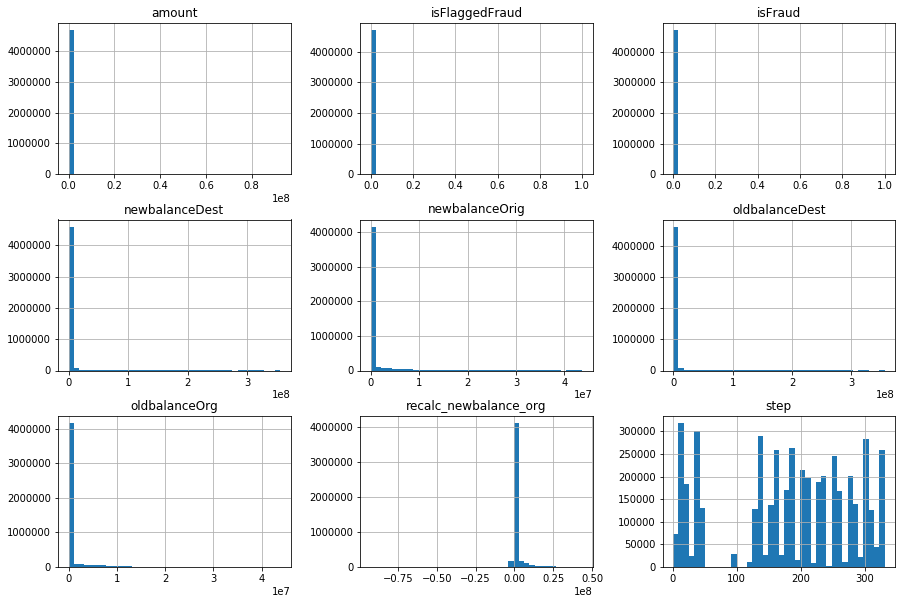

In [17]:

data.hist(bins=40, figsize=(15, 10), sharex=False, sharey=False)
plt.ticklabel_format(style='plain')
plt.show()

step


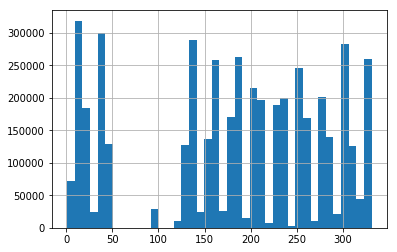

amount


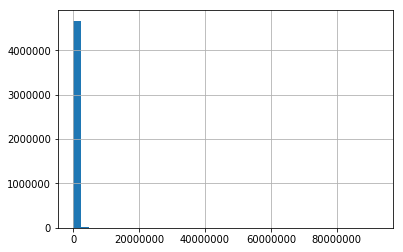

oldbalanceOrg


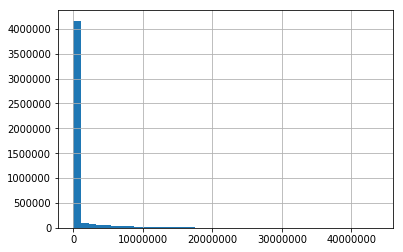

newbalanceOrig


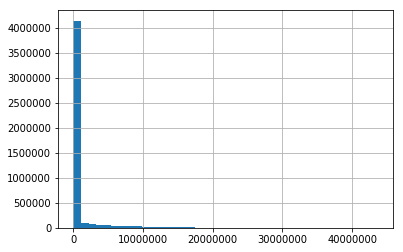

oldbalanceDest


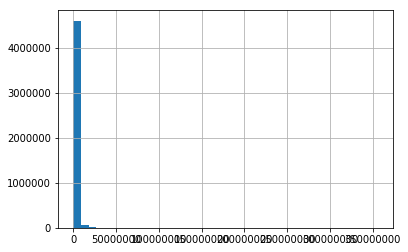

newbalanceDest


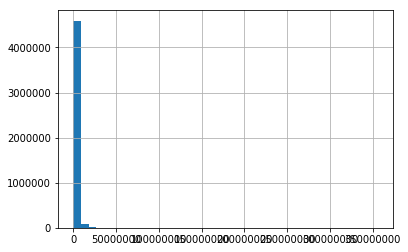

isFraud


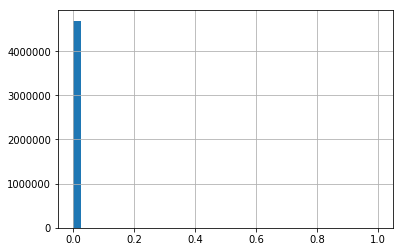

isFlaggedFraud


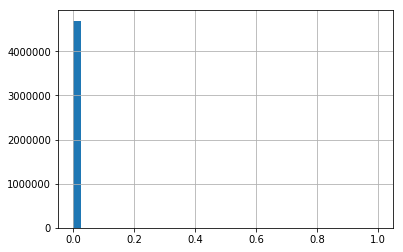

recalc_newbalance_org


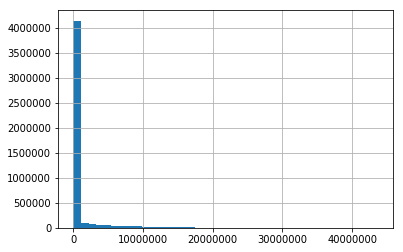

amt_gt_initBalance


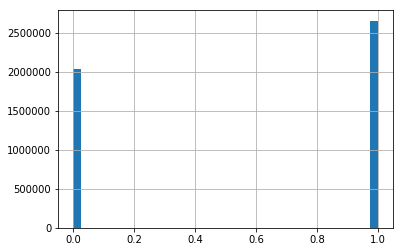

In [24]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    print(col)
    data[col].hist(bins=40)
    plt.ticklabel_format(style='plain')
    plt.show()